In [1]:
import torch
import torch.nn as nn
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

In [2]:
num_epochs = 500
batch_size = 1
learning_rate = 0.001

input_size = 222
sequence_length = 4
hidden_size = 128
num_layers = 2

In [3]:
initialize=True

In [5]:
df = pd.read_csv('./united_data_soybean.csv', index_col=0).fillna(0)
y = df['Soybean_Yield']
X = df.drop(columns=['Soybean_Yield'], axis=1)

In [6]:
class MyDataset(Dataset):
 
  def __init__(self,X,y):
    self.x_train=torch.tensor(X,dtype=torch.float32)
    self.y_train=torch.tensor(y,dtype=torch.float32)
 
  def __len__(self):
    return len(self.y_train)
   
  def __getitem__(self,idx):
    return self.x_train[idx],self.y_train[idx]

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=1)

In [8]:
train_data=MyDataset(X_train.to_numpy(), y_train.to_numpy())
train_loader=DataLoader(train_data,batch_size=batch_size,shuffle=False)

test_data=MyDataset(X_test.to_numpy(), y_test.to_numpy())
train_loader=DataLoader(test_data,batch_size=batch_size,shuffle=False)

In [9]:
X_train = torch.tensor(X_train.to_numpy(), dtype=torch.float32)
X_test = torch.tensor(X_test.to_numpy(), dtype=torch.float32)
y_train = torch.tensor(y_train.to_numpy(), dtype=torch.float32)
y_test = torch.tensor(y_test.to_numpy(), dtype=torch.float32)


In [10]:
X_train.shape

torch.Size([921, 888])

In [12]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)
    def forward(self, x):
        if initialize:
            h0 = torch.zeros(num_layers, x.size(0), hidden_size)
            c0 = torch.zeros(num_layers, x.size(0), hidden_size)
            x, _ = self.lstm(x,(h0,c0))
        else:
            x, _ = self.lstm(x)
        x = x[:, -1, :]
        x = self.linear(x)
        return x

In [13]:
model = LSTM(input_size, hidden_size, num_layers)

In [14]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (weather, labels) in enumerate(train_loader):  
        # origin shape: [N, 1, 28, 28]
        # resized: [N, 28, 28]
        weather = weather.reshape(-1, sequence_length, input_size)
        
        # Forward pass
        outputs = model(weather)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

c:\Users\Attila\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/500], Step [100/308], Loss: 1167.1013
Epoch [1/500], Step [200/308], Loss: 410.9704
Epoch [1/500], Step [300/308], Loss: 484.1165
Epoch [2/500], Step [100/308], Loss: 285.9544
Epoch [2/500], Step [200/308], Loss: 100.4613
Epoch [2/500], Step [300/308], Loss: 758.9008
Epoch [3/500], Step [100/308], Loss: 208.6516
Epoch [3/500], Step [200/308], Loss: 76.2165
Epoch [3/500], Step [300/308], Loss: 787.3502
Epoch [4/500], Step [100/308], Loss: 211.9563
Epoch [4/500], Step [200/308], Loss: 60.1473
Epoch [4/500], Step [300/308], Loss: 368.7578
Epoch [5/500], Step [100/308], Loss: 202.5061
Epoch [5/500], Step [200/308], Loss: 22.7947
Epoch [5/500], Step [300/308], Loss: 78.7641
Epoch [6/500], Step [100/308], Loss: 157.1330
Epoch [6/500], Step [200/308], Loss: 7.1109
Epoch [6/500], Step [300/308], Loss: 20.9828
Epoch [7/500], Step [100/308], Loss: 71.0466
Epoch [7/500], Step [200/308], Loss: 1.7470
Epoch [7/500], Step [300/308], Loss: 47.0052
Epoch [8/500], Step [100/308], Loss: 193.221

In [15]:
weather = X_test.reshape(-1, sequence_length, input_size)
labels = y_test
outputs = model(weather)
loss = criterion(outputs.reshape(-1), labels)
loss

tensor(1.9564, grad_fn=<MseLossBackward0>)

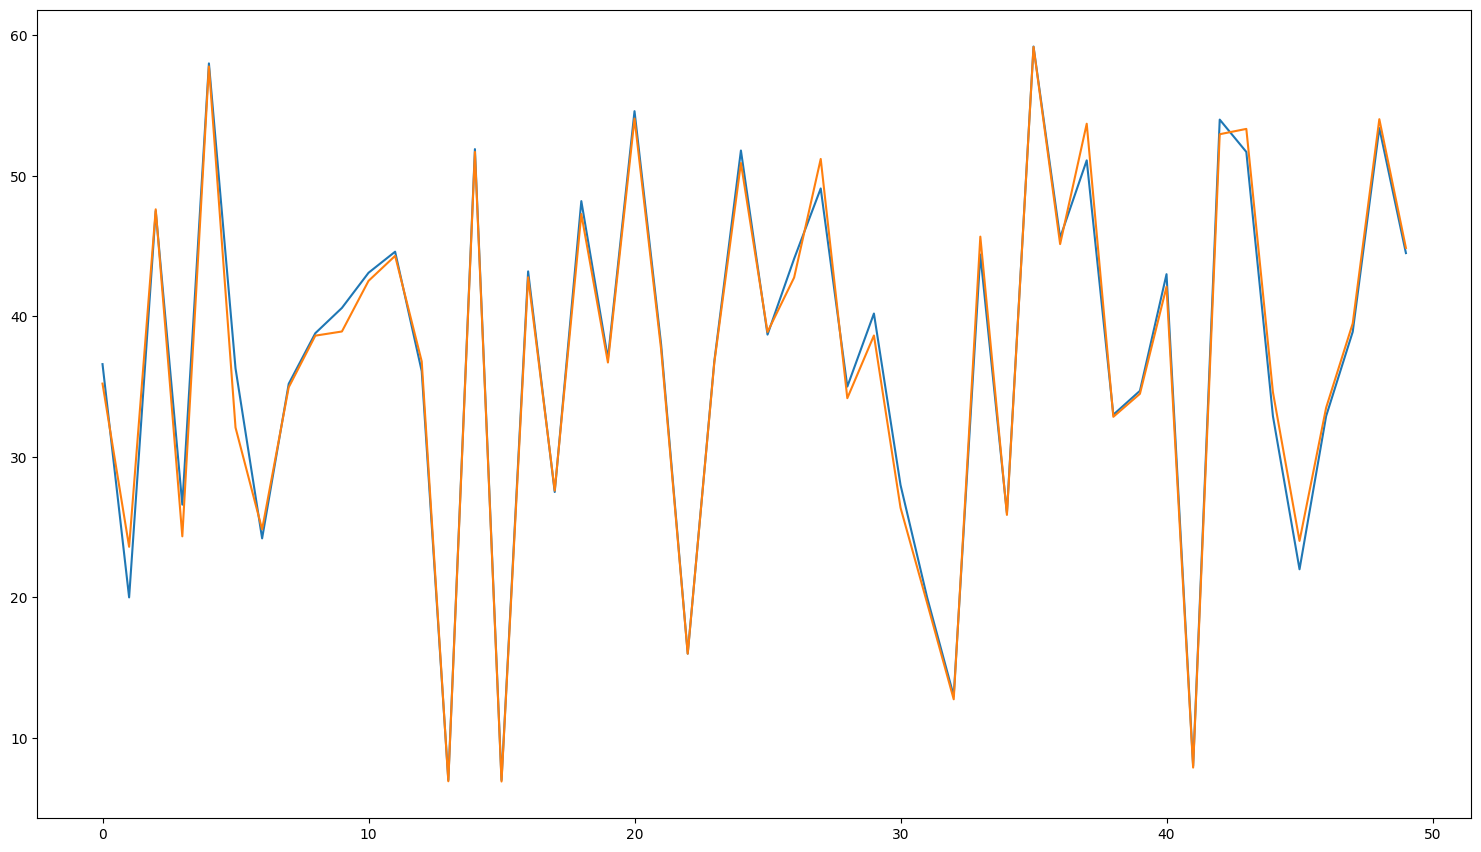

In [16]:
plt.plot(y_test[:50])
plt.plot(outputs[:50].detach())
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

In [106]:
torch.save(model.state_dict(), "lstm_1000_2_128_soybean")